# _Daily Demand Forecasting Orders - Regression model_

O objetivo aqui é criar um modelo de regressão linear capaz de prever o total de pedidos diários de uma empresa de logística.

### _Setup_

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

In [3]:
demand = pd.read_csv('Daily_Demand_Forecasting_Orders.csv', sep=';')

In [4]:
colunas = ['week_of_month', 'day_of_the_week', 'non_urgent_order', 'urgent_order','orderA', 'orderB', 'orderC', 'fiscal_order', 'order_traffic','banking_order1', 'banking_order2','banking_order3', 'target']
demand.columns = colunas

### Visão Geral

In [22]:
# formato do dataset
demand.shape

(60, 13)

In [23]:
# Tipos de dados
demand.dtypes

week_of_month         int64
day_of_the_week       int64
non_urgent_order    float64
urgent_order        float64
orderA              float64
orderB              float64
orderC              float64
fiscal_order        float64
order_traffic         int64
banking_order1        int64
banking_order2        int64
banking_order3        int64
target              float64
dtype: object

In [24]:
# Valores faltantes
demand.isna().sum()

week_of_month       0
day_of_the_week     0
non_urgent_order    0
urgent_order        0
orderA              0
orderB              0
orderC              0
fiscal_order        0
order_traffic       0
banking_order1      0
banking_order2      0
banking_order3      0
target              0
dtype: int64

In [26]:
# Estatística descritiva dos dados
demand.describe()

,week_of_month,day_of_the_week,non_urgent_order,urgent_order,orderA,orderB,orderC,fiscal_order,order_traffic,banking_order1,banking_order2,banking_order3,target
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,3.016667,4.033333,172.554933,118.920850,52.112217,109.229850,139.531250,77.396133,44504.350000,46640.833333,79401.483333,23114.633333,300.873317
std,1.282102,1.401775,69.505788,27.170929,18.829911,50.741388,41.442932,186.502470,12197.905134,45220.736293,40504.420041,13148.039829,89.602041
min,1.000000,2.000000,43.651000,77.371000,21.826000,25.125000,74.372000,0.000000,11992.000000,3452.000000,16411.000000,7679.000000,129.412000
25%,2.000000,3.000000,125.348000,100.888000,39.456250,74.916250,113.632250,1.243250,34994.250000,20130.000000,50680.500000,12609.750000,238.195500
50%,3.000000,4.000000,151.062500,113.114500,47.166500,99.482000,127.990000,7.831500,44312.000000,32527.500000,67181.000000,18011.500000,288.034500
75%,4.000000,5.000000,194.606500,132.108250,58.463750,132.171000,160.107500,20.360750,52111.750000,45118.750000,94787.750000,31047.750000,334.237250
max,5.000000,6.000000,435.304000,223.270000,118.178000,267.342000,302.448000,865.000000,71772.000000,210508.000000,188411.000000,73839.000000,616.453000


### Análise Exploratória de Dados

Para ter conhecimento do desempenho das vendas e, por conseguinte, traçar as metas mais adeaquadas, é importante conferir como se dá a distribuição do total de vendas de acordo com o dia da semana. Ccomo podermos observar abaixo, há uma tendência declinante na semana, em que as segundas-feiras apresentam o maior total de pedidos enquanto a sexta-feria possuir a menor.

In [8]:
demand.groupby('day_of_the_week')['target'].sum()

day_of_the_week
2    4292.364
3    3647.181
4    3665.064
5    3287.619
6    3160.171
Name: target, dtype: float64

Analisamos abaixo a distribuição dos diferentes tipos de pedido realizados ao longo do recorte temporal. Podemos perceber que os pedidos do tipo B e C são mais elevados do que o pedido do tipo A. No entando, vale frisar que os pedidos B e C também apresentam valores discrepantes ( _outliers_ ), o que gera um valor médio de pedidos maior em relação ao pedido A.

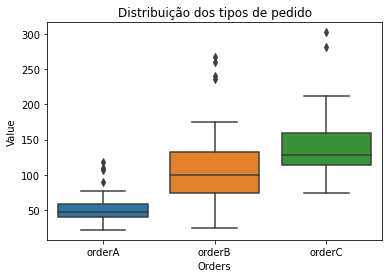

In [9]:
sns.boxplot(x='variable',y='value',data=pd.melt(demand[['orderA','orderB', 'orderC']]));
plt.xlabel('Orders');
plt.ylabel('Value');
plt.title('Distribuição dos tipos de pedido');

In [10]:
print('Valor médio do perdido A: ',demand.orderA.mean())
print('Valor médio do perdido B: ',demand.orderB.mean())
print('Valor médio do perdido C: ',demand.orderC.mean())

Valor médio do perdido A:  52.112216666666676
Valor médio do perdido B:  109.22985
Valor médio do perdido C:  139.53125000000003


Outra forma de identificar a perfomance das vendas é identificar a urgência dos pedidos. Pelo gráficos de barras abaixo, podemos observar que os pedidos não-urgentes possuem uma média maior do que os pedidos urgentes, o que é compreensível até porque a soma total de pedidos não-urgentes é muito maior do que a de urgentes. 

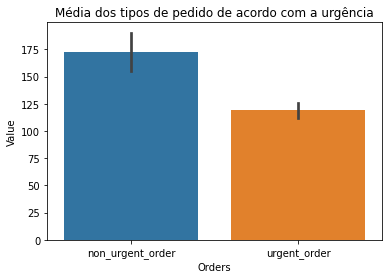

In [11]:
sns.barplot(x='variable', y='value', data=pd.melt(demand[['non_urgent_order','urgent_order']]));
plt.xlabel('Orders');
plt.ylabel('Value');
plt.title('Média dos tipos de pedido de acordo com a urgência');

In [12]:
demand[['non_urgent_order','urgent_order']].sum()

non_urgent_order    10353.296
urgent_order         7135.251
dtype: float64

### Preparação dos dados

A partir de agora, iremos fazer a preparação dos dados para o modelo de regressão linear. Primeiro, precisamos isolar a váriavel alvo ( _target variable_ ), no caso, o total de pedidos, deixando as demais variáveis como _features_ preditoras. 

Quanto à engenharia de _features_ ( _features engeneering_ ), o fato do _dataset_ se tratar de uma base de dados já tratada facilta consisderavelmente o trabalho, uma vez que a maior parte do tempo é despedida no tratamento e no pré-processamento dos dados. Tendo em vista que o _dataset_ possui poucas _features_ e poucas observações, decidiu-se por não adotar nenhuma técnica de redução de dimensionalidade, um passo crucial que influencia o desempenho de modelos de previsão, sobretudo quando se trata de _datasets_ grandes e com muitas _features_ (+50).

In [13]:
x = demand.drop('target', axis=1)
y = demand.target

### Padronização

Para garantir um resultado mais eficiente do modelo, é altamente recomendável a realização da padronização dos dados. Isso se justifica porque comumente as _features_ apresentam  grandezas diferentes, de maneira a se fazer necessário transformar os dados numa mesma escala.

Aqui, utilizamos o _Standard Scaler_ uma ferramenta de padronização de dados do _Scikit Learn_ , que faz com que a média dos dados seja igual a 0 e o desvio padrão seja igual a 1.

In [14]:
scaler = StandardScaler()

In [15]:
x_scaled = scaler.fit_transform(x)

Antes de aplicar o algoritmo de regressão, realizamos a divisão do _dataset_ entre treino e teste. Para tal, usamos o `train_test_split` também do _Scikit Learn_ para realizar a divisão dos dados. Utilizamos uma proporção de 70% dos dados para treinamento e 30% para o teste, que é uma medida comumennte adotada (poderia também ser 80%/20%).

In [16]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(x_scaled, y, test_size=0.3, random_state=42)    

In [17]:
# Shape do dataset dividido
print(X_treino.shape, X_teste.shape, Y_treino.shape, Y_teste.shape)

(42, 12) (18, 12) (42,) (18,)


### Modelo de regressão

O problema que tentamos resolver aqui é um problema de regressão: dadas variáveis independentes, desejamos prever uma variável numérica dependente, no caso, o total de pedidos (`target`)

Utilizaremos diferentes algotitmos e métricas de avaliação de desempenho para nosso modelo de predição do total de pedidos.

### Regressão Linear

In [18]:
regression = LinearRegression()

In [19]:
regression.fit(X_treino, Y_treino)

LinearRegression()

In [27]:
pred = regression.predict(X_teste)
pred

array([539.577, 207.364, 530.944, 357.394, 363.402, 213.509, 346.035,
       402.607, 308.178, 303.447, 259.246, 342.606, 323.603, 317.12 ,
       188.601, 233.126, 344.291, 263.043])

In [21]:
mean_squared_error(Y_teste, pred)

3.320929108557077e-27

Podemos observar que nosso modelo possui um desempenho bastante satisfatório, uma vez que o resultado do _mean squared error_ (MSE), sendo uma métrica sempre estritamente não negativa, que funciona assim: quanto mais próximo de zero, melhor o desempenho do modelo, pois as diferenças entre as predições e os reais valores é menor.

Esse valor sozinho não passa muitas informações, e portanto o MSE é melhor aproveitado ao comparar modelos. Por exemplo, podemos escolher o valor de 𝜆
em uma regressão ridge ou LASSO que leve ao menor MSE.

### Ridge
A regressão ridge é uma forma de regularizar a regressão linear, por meio do termo 𝜆 (alfa)que nos possibilita alterar o quanto queremos regularizar o modelo. Para 𝜆=0, a regressão ridge se torna uma regressão linear sem regularização. À medida que se aumenta o valor de 𝜆, mais regularizado se torna o modelo, ou seja, menores serão os valores de 𝛽 estimados.

A potência da regressão ridge addvém justamente do _trade-off_ viés_variância. A regressão sem regularização (𝜆=0) possui grande variância e pouco viés. Conforme aumentamos 𝜆, a variância diminui a uma taxa maior do que o viés aumenta, reduzindo assim o MSE total.

In [30]:
ridge = Ridge(alpha=1, solver="cholesky")

In [31]:
ridge.fit(X_treino, Y_treino)

Ridge(alpha=1, solver='cholesky')

In [33]:
pred_ridge = ridge.predict(X_teste)

In [36]:
mean_squared_error(Y_teste, pred_ridge)

209.12517628431436

A partir do resultado da métrica de validação `median_squared_error`, é preferível adotar o modelo de regressão linear padrão.

### Resultado

A partir desse _dataset_ foi possível criarmos um modelo de regressão linear capaz de prever o total de pedidos diários de uma empresa de logística, um instrumento importatíssimo para o planejamento estratégico empresarial.

À título de esclarecimento, vale destacar que para tornar esse modelo mais escalável, é fundamental qie a empresa tenha uma quantidade maior de dados para possibilitar um melhor treinamento do modelo e, portanto, um melhor calibramento das previsões. Para além da maturidade na cultura de dados requerida para deter esses dados históricos, é importante que haja o _deploy_ desse modelo em vista a torná-lo funcional e prestativo  uma tomada de decisões orientada a dados.